<a href="https://colab.research.google.com/github/AdelaideUniversityMathSciences/MathsForAI/blob/main/Code/nearest_neighbor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import torch
import torch.nn.functional as F
from torchvision import datasets, transforms

import matplotlib
import matplotlib.pyplot as plt

In [6]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (1.0,))])

# Training and testing datasets.
trainset = datasets.MNIST(
    root='../data', train=True,
    download=True, transform=transform)
testset = datasets.MNIST(
    root='../data', train=False,
    download=True, transform=transform)

5


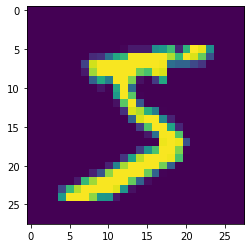

In [7]:
# Visualize an example.
example = trainset[0]
x, y = example
plt.imshow(torch.squeeze(x))
print(y)

In [8]:
# Example of list comprehension.
elems = [0, 1, 2, 3, 4, 5]
[x ** 2 for x in elems]

[0, 1, 4, 9, 16, 25]

In [9]:
images_train = torch.stack([x for x, y in trainset])
labels_train = torch.tensor([y for x, y in trainset])
images_test = torch.stack([x for x, y in testset])
labels_test = torch.tensor([y for x, y in testset])
print('images_train:', images_train.shape)
print('labels_train:', labels_train.shape)

images_train: torch.Size([60000, 1, 28, 28])
labels_train: torch.Size([60000])


In [10]:
# Flatten last 3 dimensions to obtain a vector.
x_train = torch.flatten(images_train, start_dim=-3)
x_test = torch.flatten(images_test, start_dim=-3)
print('x_train:', x_train.shape)
print('x_test:', x_test.shape)

x_train: torch.Size([60000, 784])
x_test: torch.Size([10000, 784])


In [11]:
# Obtain 2-norm distance between each pair of examples.

# Use identity
#   |u - v|^2 = u'u - 2 u'v + v'v
# to avoid constructing [n_train, n_test, n_feat] array.

# Compute dot product between each pair of (train, test) examples.
dot = torch.einsum('id,jd->ij', x_train, x_test)
print(dot.shape)

# This is equivalent to the following code (which is too slow):
#
# n_train = x_train.shape[0]
# n_test = x_test.shape[0]
# dot = torch.zeros([n_train, n_test])
# for i in range(n_train):
#   for j in range(n_test):
#     dot[i, j] = torch.dot(x_train[i], x_train[j])

torch.Size([60000, 10000])


In [12]:
# Add an extra dimension such that norms align with dot.
norm_train = torch.sum(x_train ** 2, dim=1).unsqueeze(dim=1)
norm_test = torch.sum(x_test ** 2, dim=1).unsqueeze(dim=0)
print('norm_train:', norm_train.shape)
print('norm_test:', norm_test.shape)

norm_train: torch.Size([60000, 1])
norm_test: torch.Size([1, 10000])


In [13]:
%%time
dist_euc = norm_train + norm_test - 2 * dot
# print('dist_euc:', dist_euc.shape)

CPU times: user 1.22 s, sys: 4.7 s, total: 5.92 s
Wall time: 5.9 s


In [14]:
# Find nearest neighbor for each testing example.
index_nearest = torch.argmin(dist_euc, dim=0)
# Take label of nearest training example as the prediction.
pred = labels_train[index_nearest]

# Check the accuracy of our predictions!
torch.mean((pred == labels_test).float())

tensor(0.9691)

In [15]:
# Try taking majority of k nearest neighbors.
k = 3
_, index_neighbors = torch.topk(dist_euc, k, largest=False, dim=0)
print('index_neighbors:', index_neighbors.shape)

# Take sum over one-hot representation to obtain per-class counts.
y_train = F.one_hot(labels_train).float()
print('y_train:', y_train.shape)
y_neighbors = y_train[index_neighbors]
print('y_neighbors:', y_neighbors.shape)

index_neighbors: torch.Size([3, 10000])
y_train: torch.Size([60000, 10])
y_neighbors: torch.Size([3, 10000, 10])


In [16]:
freq_neighbors = torch.sum(y_neighbors, dim=0)
print('freq_neighbors:', freq_neighbors.shape)

freq_neighbors: torch.Size([10000, 10])


In [17]:
# Take the most frequent class amongst neighbors as the prediction.

# May be necessary to break ties. Add 0.5^i for the i-th nearest neighbor.
weight = 0.5 ** (1 + torch.arange(k))
print('weight:', weight)

tie_break = torch.tensordot(weight, y_neighbors, dims=1)
torch.max(tie_break)  # Should be < 1 to avoid overwhelming frequency.

weight: tensor([0.5000, 0.2500, 0.1250])


tensor(0.8750)

In [18]:
score = freq_neighbors + tie_break
pred = torch.argmax(score, dim=1)

# Check the accuracy of our predictions!
torch.mean((pred == labels_test).float())

tensor(0.9717)

In [19]:
# Allow python to return memory to the system.
del dot, dist_euc

In [20]:
# Put it all together in a function.

def predict_knn(x_train, y_train, x_test, k, chunk_size=1000):
  # Use cat(map(f, split(x))) to avoid crashing kernel due to RAM usage.
  # This is necessary to evaluate on the training set (60k examples).
  # index_neighbors = find_neighbors(x_train, x_test, k)
  index_neighbors = torch.cat([
    find_neighbors(x_train, x, k)
    for x in torch.split(x_test, chunk_size)
  ], dim=1)
  y_neighbors = y_train[index_neighbors]
  freq_neighbors = torch.sum(y_neighbors, dim=0)
  weight = 0.5 ** (1 + torch.arange(k))
  tie_break = torch.tensordot(weight, y_neighbors, dims=1)
  score = freq_neighbors + tie_break
  return torch.argmax(score, dim=1)

def find_neighbors(x_train, x_test, k):
  dot = torch.einsum('id,jd->ij', x_train, x_test)
  norm_train = torch.sum(x_train ** 2, dim=1).unsqueeze(dim=1)
  norm_test = torch.sum(x_test ** 2, dim=1).unsqueeze(dim=0)
  dist_euc = norm_train + norm_test - 2 * dot
  _, neighbors = torch.topk(dist_euc, k, largest=False, sorted=True, dim=0)
  return neighbors

In [21]:
# Evaluate nearest neighbor for varying k.

for k in [1, 3, 10, 100]:
  pred_test = predict_knn(x_train, y_train, x_test, k)
  acc_test = torch.mean((pred_test == labels_test).float()).item()
  print('k:', k)
  print(f'test acc {acc_test:.2%}')
  print()

k: 1
test acc 96.91%

k: 3
test acc 97.17%

k: 10
test acc 96.83%

k: 100
test acc 94.44%



In [22]:
# Do the same thing for the training set (slow!!)

for k in [1, 3, 5, 100]:
  pred_train = predict_knn(x_train, y_train, x_train, k)
  acc_train = torch.mean((pred_train == labels_train).float()).item()
  print('k:', k)
  print(f'train acc {acc_train:.2%}')
  print()

k: 1
train acc 100.00%

k: 3
train acc 98.87%

k: 5
train acc 98.37%

k: 100
train acc 94.20%

